In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import joblib

import warnings
warnings.filterwarnings("ignore")

### Generación dataset randómico

In [7]:
# Configuración inicial
np.random.seed(2)
num_samples = 10000
tiempo_maximo = 50  # Máximo tiempo permitido para cruzar (en segundos)
std_edad = 1
std_tiempo_cruce = 5
std_velocidad = 6

# Generación de datos
data = {
    "edad_jugador": np.random.randint(2+std_edad, 11-std_edad, size=num_samples),  # Edad entre 3 y 90 años
    "tiempo_cruce": np.random.uniform(6, tiempo_maximo-std_tiempo_cruce, size=num_samples),  # Tiempo de cruce entre 2 y 50 segundos
    "velocidad_vehiculos": np.random.uniform(20+std_velocidad, 80-std_velocidad, size=num_samples),  # Velocidad entre 20 y 80 km/h
    "num_carriles": np.random.choice([2, 4, 6], size=num_samples),  # Número de carriles
    "num_intentos": np.random.randint(1, 4, size=num_samples),  # Intentos entre 1 y 3
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Inicializar el MinMaxScaler
scaler = MinMaxScaler()

# Escalar las características numéricas (features)
columns_to_scale = ["edad_jugador", "tiempo_cruce", "velocidad_vehiculos", "num_carriles", "num_intentos"]
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Ahora calculamos la dificultad usando las características normalizadas y ajustando por edad
def calcular_dificultad(row):
    dificultad = (
        2 * row["edad_jugador"]  # Ajuste de edad basado en la distribución normal
        + 2 * row["tiempo_cruce"]  # El tiempo de cruce tiene un impacto significativo
        + 3 * row["velocidad_vehiculos"]  # La velocidad de los vehículos tiene un gran impacto
        + 2 * row["num_carriles"]  # El número de carriles tiene un impacto moderado
        + 2 * (1 - row["num_intentos"])  # Más intentos implica mayor dificultad
    )
    
    # Asegurarse de que la dificultad esté en el rango [1, 10]
    return np.clip(dificultad, 1, 10)

# Aplicar la función a cada fila para calcular la dificultad
df["dificultad"] = df.apply(calcular_dificultad, axis=1)

# Guardar el dataset ajustado
file_path = "dataset_juego_cruce_calle.csv"
df.to_csv(file_path, index=False)

print(f"Dataset generado y guardado como {file_path}")

Dataset generado y guardado como dataset_juego_cruce_calle.csv


### Guardado del escalador como .pkl

In [8]:
# Guardar el escalador para su uso posterior
nombre_escalador = 'mmscaler_juego_cruce_calle.pkl'
joblib.dump(scaler, f'{nombre_escalador}')
print(f"Escalador guardado como '{nombre_escalador}'")

Escalador guardado como 'mmscaler_juego_cruce_calle.pkl'


### Pequeño análisis exploratorio

In [9]:
df = pd.read_csv(r'dataset_juego_cruce_calle.csv')

In [10]:
print(df['dificultad'].min())
print(df['dificultad'].max())

1.0
10.0


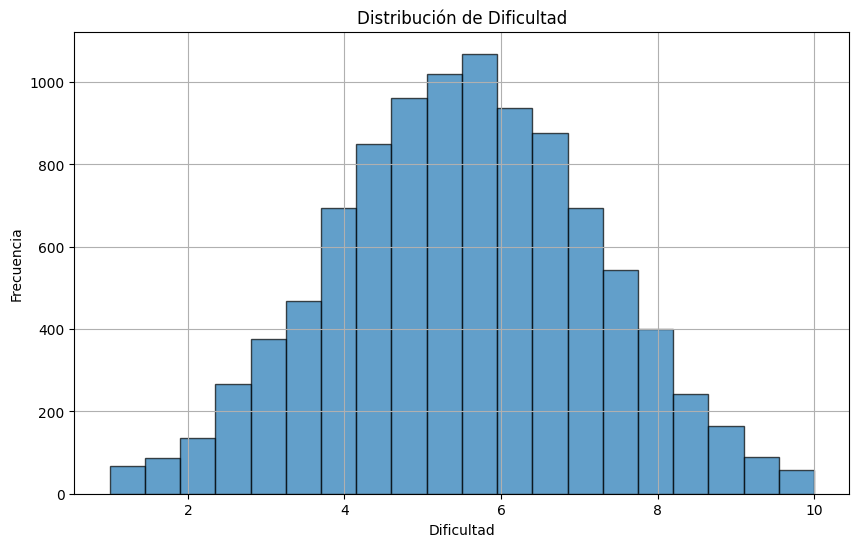

In [11]:
# Visualización de la distribución de la dificultad
plt.figure(figsize=(10, 6))
plt.hist(df["dificultad"], bins=20, edgecolor="black", alpha=0.7)
plt.title("Distribución de Dificultad")
plt.xlabel("Dificultad")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

### Entrenamiento del modelo

In [12]:
# Dividir datos en entrenamiento y prueba
X = df[["edad_jugador", "tiempo_cruce", "velocidad_vehiculos", "num_carriles", "num_intentos"]]
y = df["dificultad"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicción
y_pred = lr_model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
print(f"MSE del Linear Model: {mse}")
print(f"RMSE del Liner Model: {np.sqrt(mse)}")


MSE del Linear Model: 0.0006255874533595779
RMSE del Liner Model: 0.025011746307676677


### Guardado del modelo como .pkl

In [13]:
# Guardar el modelo
nombre_modelo = 'modelo_juego_cruce_calle.pkl'
joblib.dump(lr_model, nombre_modelo)
print(f"Modelo guardado como '{nombre_modelo}'")

Modelo guardado como 'modelo_juego_cruce_calle.pkl'


### Ejemplo de predicciones

Las columnas están repartidas de la siguiente manera:
- Columna01 --> Edad
- Columna02 --> Tiempo de cruce en segundos
- Columna03 --> Velocidad de los vehículos en km/h
- Columna04 --> Número de carriles
- Columna05 --> Número de intentos

In [14]:
# Cargar el modelo RandomForestRegressor
rf_model_loaded = joblib.load(f"{nombre_modelo}")
print("Modelo cargado correctamente.")

# Cargar el escalador
scaler_loaded = joblib.load(f"{nombre_escalador}")  # Cambia el nombre si es necesario
print("Escalador cargado correctamente.")

# Nuevos datos de ejemplo (sin escalar)
nuevos_datos = [
    [3, 6.0, 25, 2, 1],
    [3, 10.5, 40, 2, 1],  # Ejemplo: edad=10, tiempo_cruce=16.5, velocidad_vehiculos=60, num_carriles=4, num_intentos=1
    [5, 13.6, 50, 4, 1],
    [7, 24.0, 65, 4, 2],
    [9, 12.0, 70, 6, 3],
    [10, 20, 75, 6, 3],
    [10, 48, 80, 6, 3]
]

# Escalar los nuevos datos usando el escalador cargado
nuevos_datos_escalados = scaler_loaded.transform(nuevos_datos)

# Realizar la predicción con el modelo cargado
dificultades_predichas = rf_model_loaded.predict(nuevos_datos_escalados)

# Mostrar resultados
print()
for i, pred in enumerate(dificultades_predichas):
    print(f"Dificultad predicha para el jugador {i + 1}: {pred}")


Modelo cargado correctamente.
Escalador cargado correctamente.

Dificultad predicha para el jugador 1: 1.9453926496522682
Dificultad predicha para el jugador 2: 3.1113777228688866
Dificultad predicha para el jugador 3: 5.556949780965971
Dificultad predicha para el jugador 4: 6.691688688810791
Dificultad predicha para el jugador 5: 7.054693453465341
Dificultad predicha para el jugador 6: 8.108411981941146
Dificultad predicha para el jugador 7: 9.852837165024173


In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# Entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Guardar el modelo entrenado
model_filename = 'modelo_dificultad.pkl'
joblib.dump(model, model_filename)
print(f"Modelo guardado como '{model_filename}'")


Mean Squared Error: 0.0006255874533595779
Modelo guardado como 'modelo_dificultad.pkl'
